In [1]:
from setup_module import init_setup, import_data
from setup_module import import_data,save_and_load_list
import numpy as np
from classification_module import init_classification, combine_accuracy_graphs
import os



In [2]:
def init_setup():
    # check if there isnt a pre-prepared data
    if not os.path.exists("data"):
        # Create the folder if it doesn't exist
        os.makedirs("data")
    if not os.listdir("data"):
        filepath = "/home/bendegani/AMC_v2/GOLD_XYZ_OSC.0001_1024.hdf5"
        import_data(filepath)
    idx = 2
    print("loading data")
    # load the data
    samples = save_and_load_list(2, "cumulants_vec", idx)
    sample_dx = save_and_load_list(2, "cum_dx_vec", idx)
    sample_real = save_and_load_list(2, "cum_real_vec", idx)
    sample_imag = save_and_load_list(2, "cum_imag_vec", idx)
    labels = save_and_load_list(2, "labels", idx)
    snr = save_and_load_list(2, "snr_vec", idx)


    return samples, sample_dx, sample_real, sample_imag, labels, snr

# c_20 # c_21  # c_40# c_41# c_42# c_60  # c_63# c_80

def cumulant_fix_complex(cumulants):
    features_vec = []
    for ii in range(len(cumulants)):
        cum_abs = (abs(cumulants[ii]))
        # initiate output
        feats = []
        # for jj in range(len(cum_abs)):
        #     feats.append((cum_abs[jj]))
        feats.append((cum_abs[0])/cum_abs[1])
        feats.append((cum_abs[2])/cum_abs[3])
        feats.append((cum_abs[5])/cum_abs[6])
        
        feats.append(pow((cum_abs[1]),2)/cum_abs[4])
        feats.append(pow((cum_abs[3]),2)/cum_abs[7])
        
        feats.append(pow((cum_abs[2]),3)/pow(cum_abs[5],2))
        feats.append(pow((cum_abs[1]),8)/pow(cum_abs[7],1))

        features_vec.append(feats)
    return features_vec

# c_20  # c_40# c_60 # c_80

def cumulant_fix_iq(cum_real, cum_imag):
    # Gets the features vector from the cumulants
    features_vec = []
    for ii in range(len(cum_real)):
        real_abs = (abs(cum_real[ii]))
        imag_abs = (abs(cum_imag[ii]))
        # initiate output
        feats = []
        for jj in range(len(real_abs)):
            feats.append((imag_abs[jj])/real_abs[jj]) 
            # feats.append((real_abs[jj]))
            # feats.append((imag_abs[jj]))
        feats.append(pow(real_abs[0],3)/imag_abs[2])
        feats.append(pow(imag_abs[0],3)/real_abs[2])
        feats.append(pow(real_abs[1],2)/imag_abs[3])
        feats.append(pow(imag_abs[1],2)/real_abs[3])
        features_vec.append(feats)
    return features_vec

In [3]:

samples, sample_dx, sample_real, sample_imag, labels, snr = init_setup()


loading data


In [4]:
print("fixing for absolute value")
cumulants_vec = cumulant_fix_complex(samples)
cum_dx_vec = cumulant_fix_complex(sample_dx)
cum_iq_vec = cumulant_fix_iq(sample_real, sample_imag)
# convert to array
print("convert data")
labels = np.array(labels)
snr = np.array(snr)
samples = np.array(cumulants_vec)
samples_dx = np.array(cum_dx_vec)
sample_iq = np.array(cum_iq_vec)
sample_comb = np.concatenate((samples, samples_dx), 1)
    

fixing for absolute value
convert data


In [5]:

easy_mode = 1
group1 = [
        "OOK",
        "AM-SSB-WC",
        "AM-SSB-SC",
        "AM-DSB-WC",
        "AM-DSB-SC",
        "FM",
        "GMSK",
        "OQPSK",
    ]  # Low Order and Analog
group2 = [
        "4ASK",
        "8ASK",
        "16QAM",
        "32QAM",
        "64QAM",
        "128QAM",
        "256QAM",
    ]  # ASK and QAM
group3 = [
        "BPSK",
        "QPSK",
        "8PSK",
        "16PSK",
        "32PSK",
        "16APSK",
        "32APSK",
        "64APSK",
        "128APSK",
    ]  # PSK and APSK

if easy_mode == 1:
    easy_mods = [
        "OOK",
        "4ASK",
        "BPSK",
        "QPSK",
        "8PSK",
        "16QAM",
        "AM-SSB-SC",
        "AM-DSB-SC",
        "FM",
        "GMSK",
        "OQPSK",
    ]
    easy_mask = np.isin(labels, easy_mods)
    labels = labels[easy_mask]
    snr = snr[easy_mask]
    samples = samples[easy_mask]
    sample_comb = sample_comb[easy_mask]
    sample_iq = sample_iq[easy_mask]
    easy_mask = np.isin(labels, easy_mods)
    labels = labels[easy_mask]
    snr = snr[easy_mask]
    

    group1 = np.array(group1)[np.isin(group1,easy_mods)]
    group2 = np.array(group2)[np.isin(group2,easy_mods)]
    group3 = np.array(group3)[np.isin(group3,easy_mods)]
    
groups = [group1, group2, group3]

we are here
classification for cumulants...
change
Classify per SNR
Classify per Label
saved plots
Saved plot train_for_10_SNR_cumulants/feature_1.png
Saved plot train_for_10_SNR_cumulants/feature_2.png
Saved plot train_for_10_SNR_cumulants/feature_3.png
Saved plot train_for_10_SNR_cumulants/feature_4.png
Saved plot train_for_10_SNR_cumulants/feature_5.png
Saved plot train_for_10_SNR_cumulants/feature_6.png
Saved plot train_for_10_SNR_cumulants/feature_7.png
change
Classify per SNR
Classify per Label
saved plots
Saved plot train_for_0_SNR_cumulants/feature_1.png
Saved plot train_for_0_SNR_cumulants/feature_2.png
Saved plot train_for_0_SNR_cumulants/feature_3.png
Saved plot train_for_0_SNR_cumulants/feature_4.png
Saved plot train_for_0_SNR_cumulants/feature_5.png
Saved plot train_for_0_SNR_cumulants/feature_6.png
Saved plot train_for_0_SNR_cumulants/feature_7.png
classification for cumulants+dx...
change
Classify per SNR
Classify per Label
saved plots
Saved plot train_for_10_SNR_cumulan

/home/bendegani/git_graphs/Journal_Graphs/classification_module.py:157: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 4))


Saved plot train_for_10_SNR_cumulants_iq/feature_1.png
Saved plot train_for_10_SNR_cumulants_iq/feature_2.png
Saved plot train_for_10_SNR_cumulants_iq/feature_3.png
Saved plot train_for_10_SNR_cumulants_iq/feature_4.png
Saved plot train_for_10_SNR_cumulants_iq/feature_5.png
Saved plot train_for_10_SNR_cumulants_iq/feature_6.png
Saved plot train_for_10_SNR_cumulants_iq/feature_7.png
Saved plot train_for_10_SNR_cumulants_iq/feature_8.png
change
Classify per SNR


/home/bendegani/git_graphs/Journal_Graphs/classification_module.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 6))
/home/bendegani/git_graphs/Journal_Graphs/classification_module.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 6))
/home/bendegani/git_graphs/Journal_Graphs/classification_module.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

Classify per Label


/home/bendegani/git_graphs/Journal_Graphs/classification_module.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 6 * num_plots))


saved plots


/home/bendegani/git_graphs/Journal_Graphs/classification_module.py:157: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 4))


Saved plot train_for_0_SNR_cumulants_iq/feature_1.png
Saved plot train_for_0_SNR_cumulants_iq/feature_2.png
Saved plot train_for_0_SNR_cumulants_iq/feature_3.png
Saved plot train_for_0_SNR_cumulants_iq/feature_4.png
Saved plot train_for_0_SNR_cumulants_iq/feature_5.png
Saved plot train_for_0_SNR_cumulants_iq/feature_6.png
Saved plot train_for_0_SNR_cumulants_iq/feature_7.png
Saved plot train_for_0_SNR_cumulants_iq/feature_8.png


/home/bendegani/git_graphs/Journal_Graphs/classification_module.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


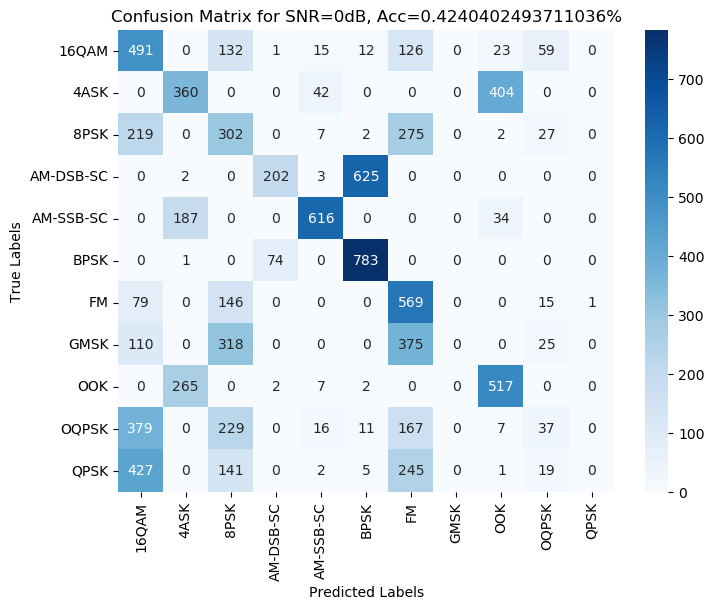

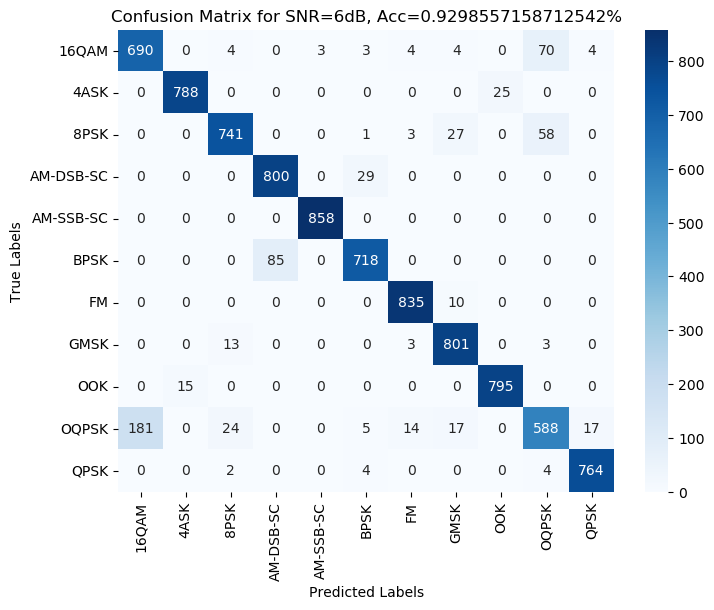

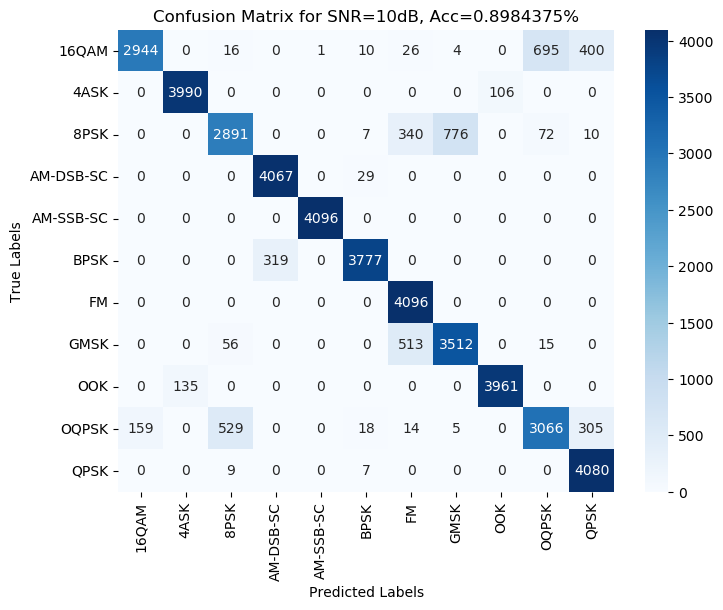

<Figure size 1000x1800 with 0 Axes>

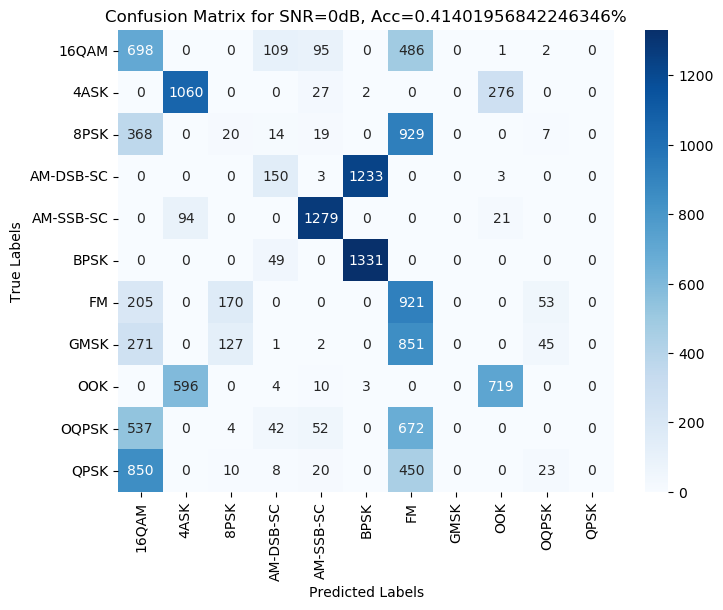

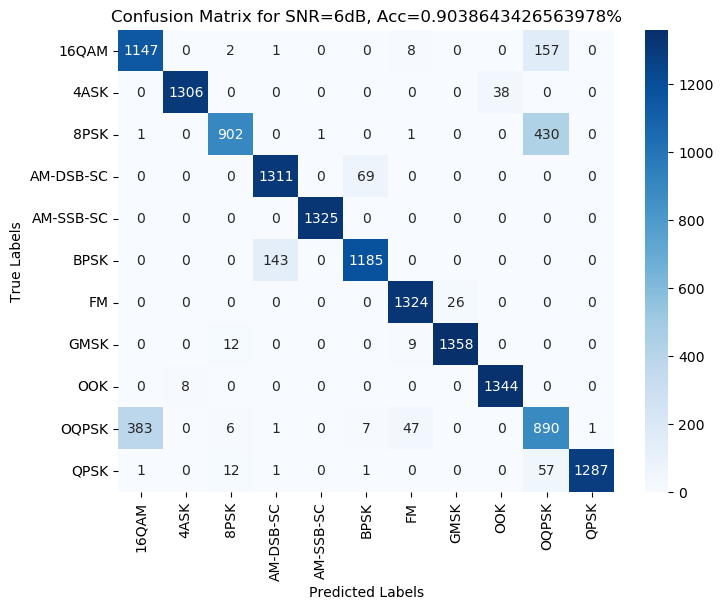

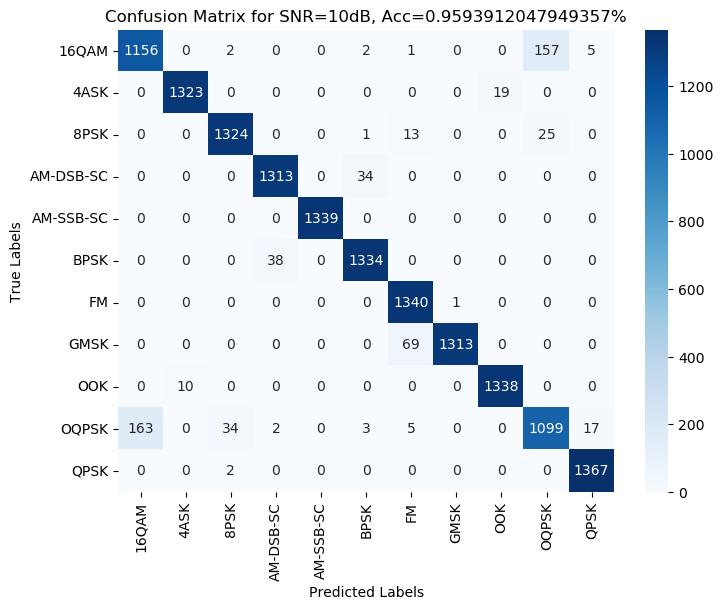

<Figure size 1000x1800 with 0 Axes>

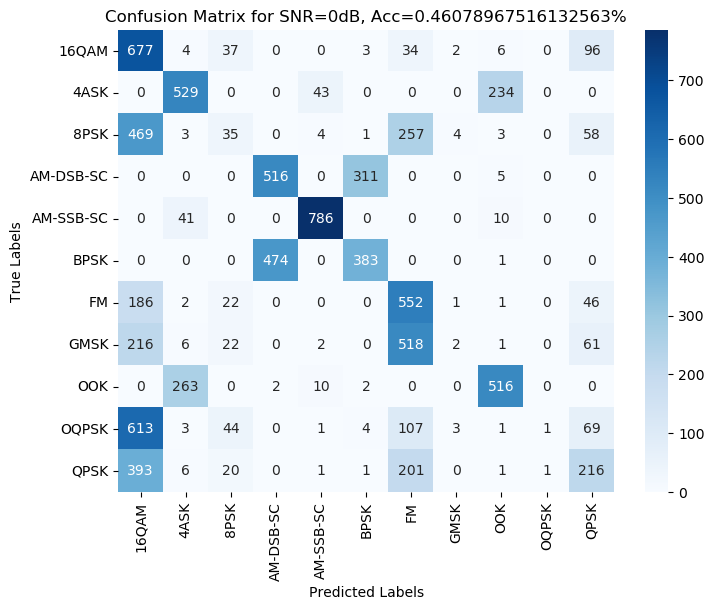

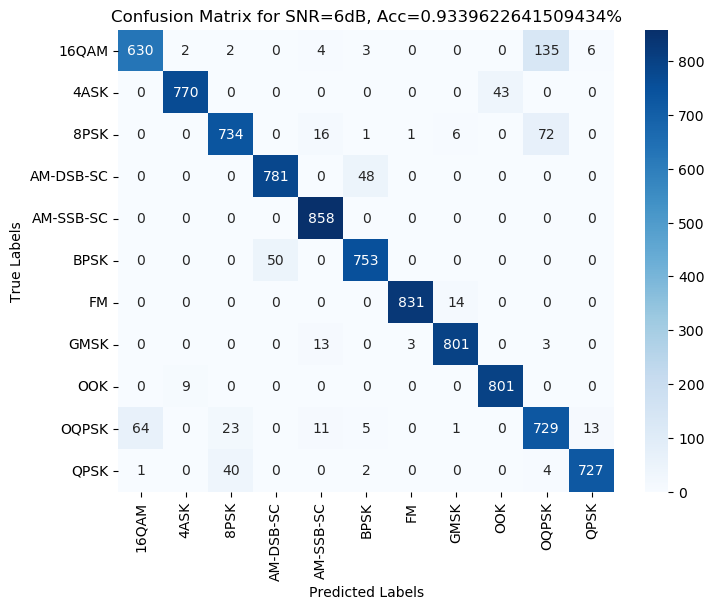

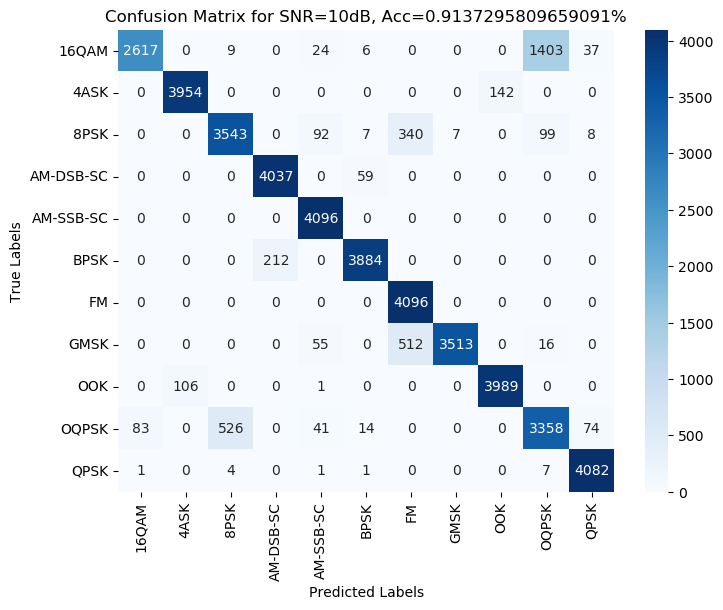

<Figure size 1000x1800 with 0 Axes>

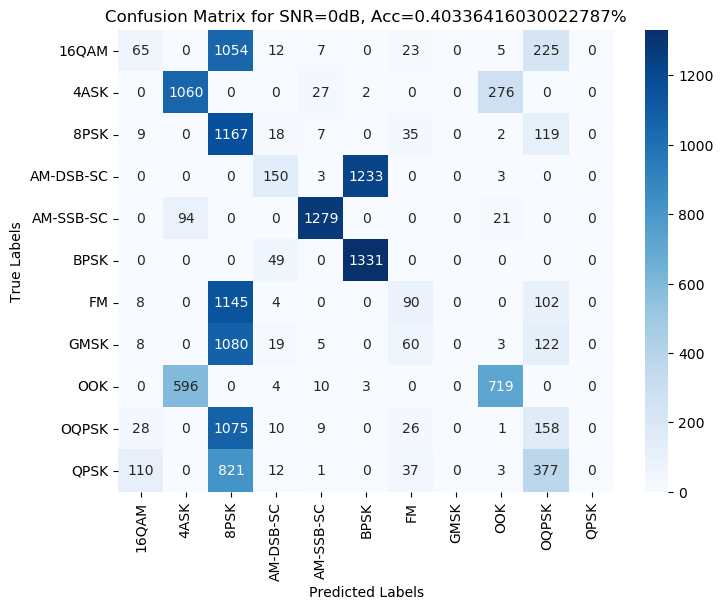

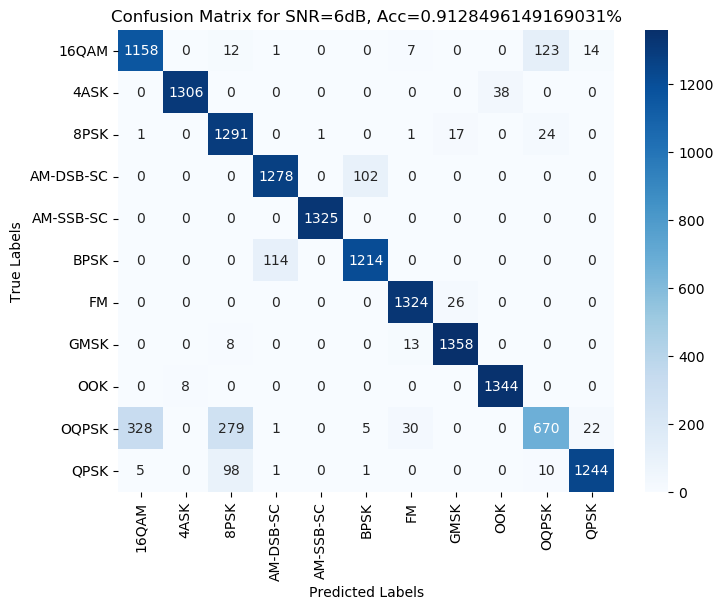

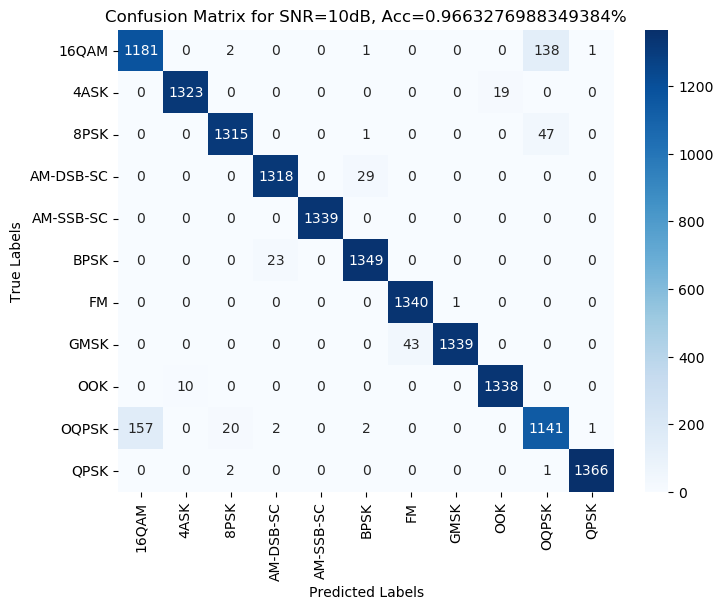

<Figure size 1000x1800 with 0 Axes>

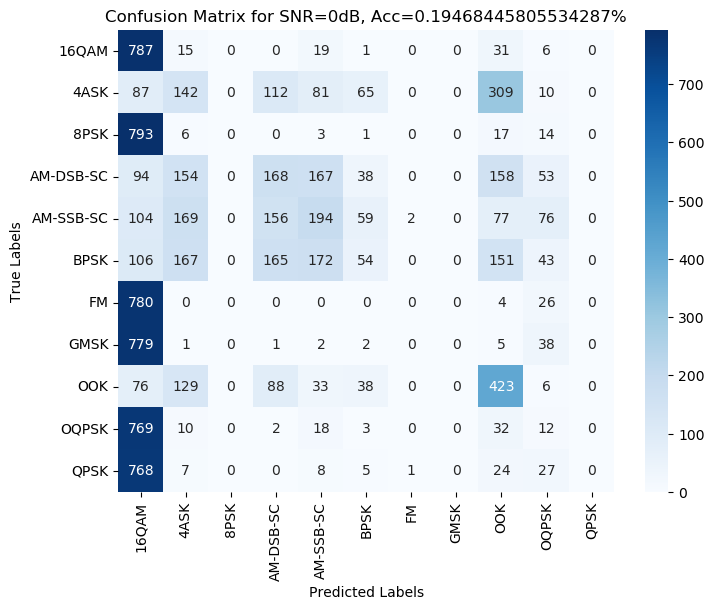

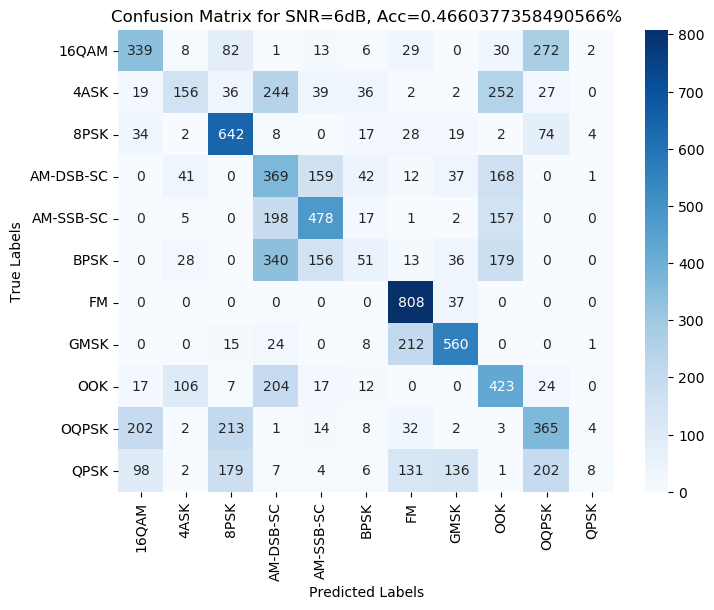

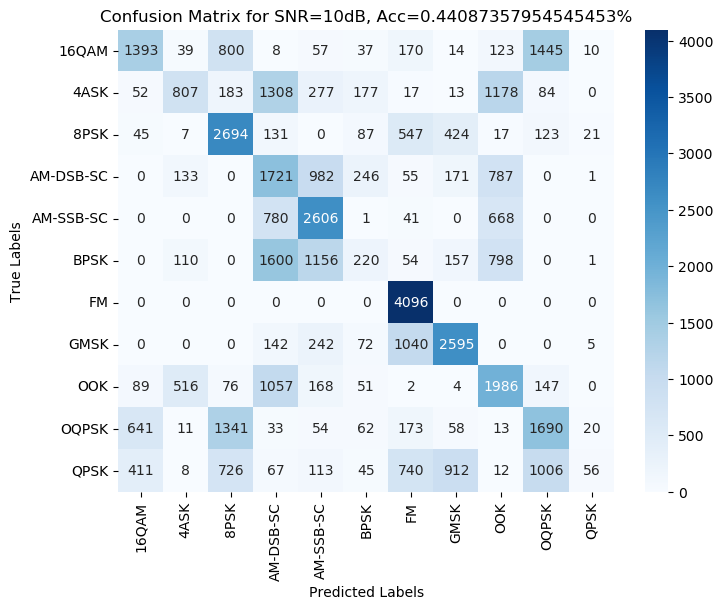

<Figure size 1000x1800 with 0 Axes>

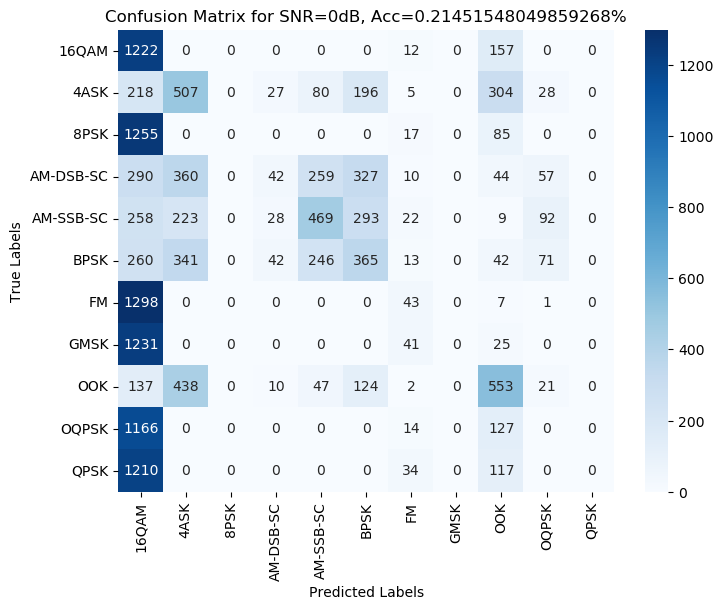

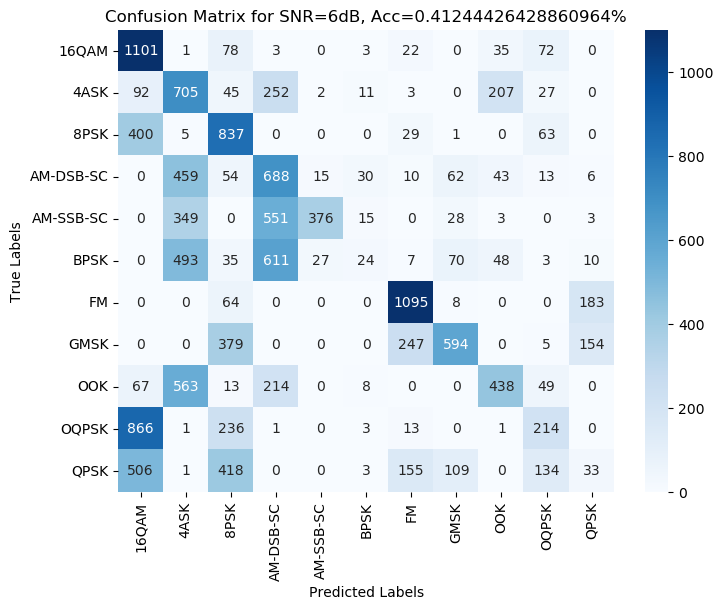

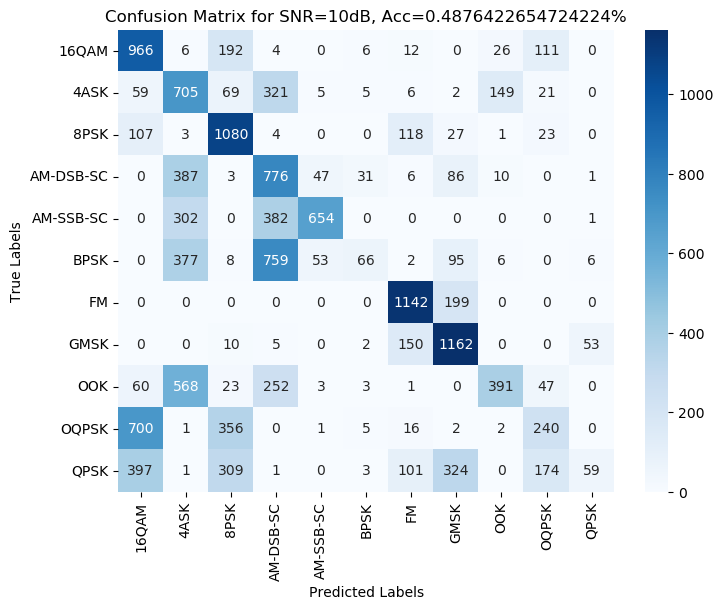

<Figure size 1000x1800 with 0 Axes>

In [6]:

print("we are here")
train_tresh = 10
print("classification for cumulants...")
accuracy_data10 = init_classification(samples, labels, snr, "cumulants", groups, easy_mode, train_tresh)
accuracy_data11 = init_classification(samples, labels, snr, "cumulants", groups, easy_mode, train_tresh-10)

print("classification for cumulants+dx...")
accuracy_data20 = init_classification(sample_comb, labels, snr, "cumulants_with_dx", groups, easy_mode, train_tresh)
accuracy_data21 = init_classification(sample_comb, labels, snr, "cumulants_with_dx", groups, easy_mode, train_tresh-10)
print("classification for cumulants IQ...")
accuracy_data30 = init_classification(sample_iq, labels, snr, "cumulants_iq", groups, easy_mode, train_tresh)
accuracy_data31 = init_classification(sample_iq, labels, snr, "cumulants_iq", groups, easy_mode, train_tresh-10)

combine_accuracy_graphs(accuracy_data10, accuracy_data20, accuracy_data30, train_tresh)
combine_accuracy_graphs(accuracy_data11, accuracy_data21, accuracy_data31, train_tresh-10)